# Testing M1 reachability upon stimulation with PGE2, INFg and LPS (8.24.2020)

In [1]:
import pypint

This notebook has been executed using the docker image `colomoto/colomoto-docker:2020-08-01`

In [2]:
model = pypint.upload()

AttributeError: module 'pypint' has no attribute 'upload'

Let's define the M1 global attractor

In [ ]:
M1H = "FCGR=0, IL4RA=0, IL10R=0, EP4R=0, TNFa=1, IL12=1, CD80=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, STAT3=0, TGFb=0, CD163=0"

In [ ]:
model.having(PGE2=1, IFNg=1, LPS=1).reachability(goal)

Let's study the attractor probability evolution over time using MaBoSS

In [ ]:
import maboss
import ginsim

In [ ]:
lrg2 = ginsim.load("/tmp/colomotomvi_222x_Network_24AUG.zginml")

In [ ]:
mbs = ginsim.to_maboss(lrg2)

In [ ]:
mbs.network.set_istate("PGE2_e", [0, 1])
mbs.network.set_istate("LPS", [0, 1])
mbs.network.set_istate("IFNg", [0, 1])

In [ ]:
#maboss.wg_set_output(mbs)
maboss.set_output(mbs, ["TNFa", "STAT1", "RelA", "IL10", "CD206", "Arg1"])
simres = mbs.run()
simres.plot_trajectory()

In [ ]:
simres.plot_piechart()

# 3. Phenotype switching and reachability analysis (8.25.20)

In [3]:
import pypint
import maboss
import ginsim


In order to study macrophage plasticity, a reachability analysis was performed using Pint and MaBoSS. First, the activated macrophage phenotypes (`M1`, `M2a` and `M2c`) were defined. Next, an algorithm was developed to study the potentialities in the phenotype switching for the 6 possible combinations. By the use of Pint, first, it was analysed wether it was possible to reach a specific final state starting from a given initial state and input conditions. If the reachability appears to be possible, MaBoSS is used to asses transient and final state probabilities and pathway switches over time. If the reachability is not possible, the analysis stops at first step (Pint). 

Results are displayed as two trajectory graphs and one pie chart. The first trajectory graph represents the transient/final state probabilities after the simulation is assessed with MaBoSS (this graph will be used for the dicussion). Its output displays the full battery of markers of the initial and final state. The second trajectory graph constitutes a simplification of the prior one, in which just two surface markers, specific for the initial and the final state, were chosen. Each curve within a trajectory graph represents a specific combination of nodes that appear to be simultaneously activated (each curve is defined in the graph legend). Finally, the pie chart shows the proportion of states displayed at the end of the simulation.

By the use of Pint function  `one_shot_mutations_for_cut` we tested which nodes or node sets where critical for the reachability of the desired state and, finally, with Pint function `cutsets`, we identified nodes or node sets, together with their local states, that were common in every path drawn between the initial and the final state.

#### Variables

The variable build up for this analysis was performed considering the following formula <br><br>

`Mxo -> Mx1 + Mx1_input; xo=1, 2a, 2c and x1=1, 2a, c` <br><br>
e.g. <br>
`M1 -> M2a + M2a_input` <br><br>

Variables (defined in general term):

* `reachMxoMx1`: tests reachability starting from xo to x1. <br>
* `psMxoMx1`: holds the model in pint format (will be used to generate the first trajectory graph and pie chart). <br>
* `psMxoMx1_simp`: holds the model in pint format (will be used to generate the second trajectory graph). <br>
* `simMxox1`: performs the simulation according previously defined initial conditions (`Mxo` + `Mx1_input`) and parameters (`time_tick` and `max_time`) for `psMxoMx1`.<br>
* `simMxoMx1_simp`: performs the simulation according previously defined initial conditions (`Mxo` + `Mx1_input`) and parameters (`time_tick` and `max_time`) for `psMxoMx1_simp`. <br>
* `mutMxox1`: displays sets of mutations (ectopic expression or KOs) sufficient and necessary to avoid the reachability of `Mx1` from Mxo. <br>
* `cutMxox1`: displays sets of local states which that appear at every single path to reach Mx1 from `Mxo` (note that this sets can appear at either same or distinct timepoints when comparing different paths)


In [6]:
lrg = ginsim.load("/tmp/colomotoe2ry_nqg_Network_24AUG.zginml")
model = ginsim.to_pint(lrg)

## Reachability analysis *pint*

In [7]:
# define a Mx phenotype
M1 = "STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1"
M2a = "STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0"
M2c = "STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0"


## M1 -> M2a

Minimal perturbations to avoid goal reachability:


This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 3 automata. Use `maxsize` argument to change.

[{'IFNgR': 1}, {'P2R': 1}, {'CSF2RA': 1}, {'IL1R': 1}, {'TLR4': 1}, {'IL4RA': 0}, {'EP4R': 1}]
 
Cutsets:


This computation is an *under-approximation*: returned cut-sets are all valid, but they may be non-minimal, and some cut-sets may be missed.

Limiting results to cut-sets with at most 10 elements. Use `maxsize` argument to change.

[{'IFNgR': 0}, {'P2R': 0}, {'CSF2RA': 0}, {'IL6R': 0}, {'IL1R': 0}, {'TLR4': 0}, {'IL4RA': 1}, {'EP4R': 0}, {'_pint_goal': 1}]
 
MaBoSS simulation (simplified results are displayed in the second trajectory graph):


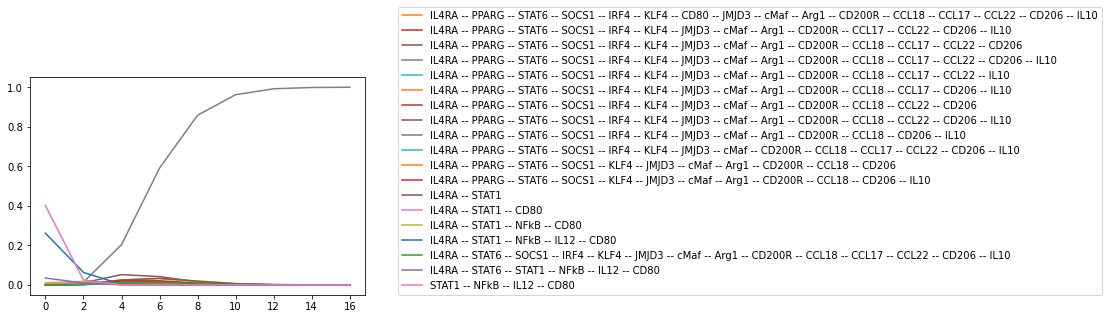

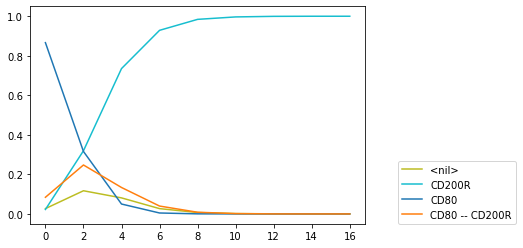

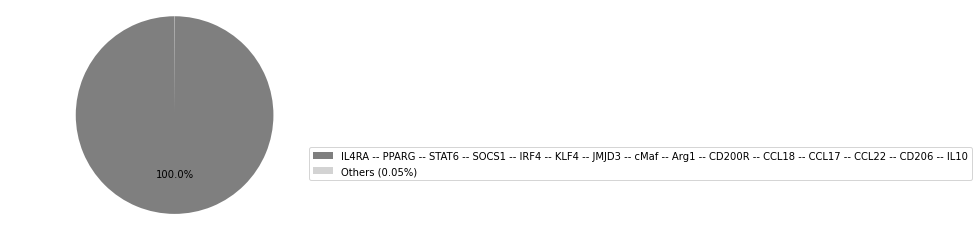

In [8]:
# simple reachability analysis: M(a) -> M(b) with M(b) inputs

#M1->M2a with M2a inputs

reachM1M2a = model.having(IL4=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).reachability(M2a)
if reachM1M2a == True:
    psM1M2a = ginsim.to_maboss(lrg)
    maboss.set_output(psM1M2a, ["IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "NFkB", "STAT1", "IL12", "CD80"])
    psM1M2a.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM1M2a, ["CSF2RA", "FCGR", "IL4RA", "IL10R", "EP4R", "ERK", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "STAT3", "TGFb", "CD163"], [1, 0])
    maboss.set_nodes_istate(psM1M2a, ["IL4", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "cPLA2a", "PGE2", "COX2", "Ca2"], [0, 1])
    maboss.set_nodes_istate(psM1M2a, ["IFNgR", "P2R", "IL6R", "IL1R", "TLR4"], [0.5, 0.5])
    simM1M2a = psM1M2a.run()
    simM1M2a.plot_trajectory()
    psM1M2a_simp = psM1M2a
    maboss.set_output(psM1M2a_simp, ["CD80", "CD200R"])
    simM1M2a_simp = psM1M2a_simp.run()
    simM1M2a_simp.plot_trajectory()
    simM1M2a.plot_piechart()
    pypsM1M2a = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability:")
    mutM1M2a = pypsM1M2a.having(IL4=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).oneshot_mutations_for_cut(M2a, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM1M2a)
    print(" ")
    print("Cutsets:")
    cutM1M2a = pypsM1M2a.having(IL4=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).cutsets(M2a, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM1M2a)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")
    

In [11]:
model2=ginsim.to_maboss(lrg)
model2.update_parameters(time_tick=2, max_time=4)
maboss.set_output(model2, ["IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "NFkB", "STAT1", "IL12", "CD80"])
model2.plot_piechart()

AttributeError: 'Simulation' object has no attribute 'plot_piechart'

## M1 -> M2c

In [ ]:
#M1->M2c with M2c inputs

reachM1M2c = model.having(IL10_e=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).reachability(M2c)
if reachM1M2c == True:
    psM1M2c = ginsim.to_maboss(lrg)
    maboss.set_output(psM1M2c, ["IL10R", "SOCS3", "IL1Ra", "CD206", "IL10", "STAT3", "TGFb", "CD163", "NFkB", "STAT1", "IL12", "CD80"])
    psM1M2c.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM1M2c, ["CSF2RA", "FCGR", "IL4RA", "IL10R", "EP4R", "ERK", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "STAT3", "TGFb", "CD163"], [1, 0])
    maboss.set_nodes_istate(psM1M2c, ["IL10_e", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "cPLA2a", "PGE2", "COX2", "Ca2"], [0, 1])
    maboss.set_nodes_istate(psM1M2c, ["IFNgR", "P2R", "IL6R", "IL1R", "TLR4"], [0.5, 0.5])
    simM1M2c = psM1M2c.run()
    simM1M2c.plot_trajectory()
    psM1M2c_simp = psM1M2c
    maboss.set_output(psM1M2c_simp, ["CD80", "CD163"])
    simM1M2c_simp = psM1M2c_simp.run()
    simM1M2c_simp.plot_trajectory()
    simM1M2c.plot_piechart()
    pypsM1M2c = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability:")
    mutM1M2a = pypsM1M2a.having(IL10_e=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).oneshot_mutations_for_cut(M2c, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM1M2a)
    print(" ")
    print("Cutsets:")
    cutM1M2c = pypsM1M2c.having(IL10_e=1, STAT5=1, STAT1=1, IRF5=1, IRF3=1, IFNb=1, NFkB=1, RelA=1, IL1a=1, IFNa=1, iNOS=1, IL1b=1, TNFa=1, IL12=1, CCL4=1, CCL2=1, CD80=1, CCR7=1, TBK1=1, TRAF6=1, JNK=1, p38=1, MNK1=1, SOCS3=1, AP1=1, IL6=1, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=0, IL10=0, STAT3=0, TGFb=0, CD163=0, cPLA2a=1, PGE2=1, COX2=1, Ca2=1).cutsets(M2c, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM1M2a)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")

## M2a -> M1

In [ ]:
#M2a->M1 with M2c inputs

reachM2aM1 = model.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).reachability(M1)
if reachM2aM1 == True:
    psM2aM1 = ginsim.to_maboss(lrg)
    maboss.set_output(psM2aM1, ["STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "cPLA2a", "PGE2", "COX2", "Ca2", "IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10"])
    psM2aM1.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM2aM1, ["IFNgR", "IL6R", "IL1R", "TLR4", "FCGR", "IL10R", "EP4R", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "ERK", "STAT3", "TGFb", "CD163", "cPLA2a", "PGE2", "COX2", "Ca2"], [1, 0])
    maboss.set_nodes_istate(psM2aM1, ["IFNg", "LPS", "IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10"], [0, 1])
    maboss.set_nodes_istate(psM2aM1, ["P2R"], [0.5, 0.5])
    simM2aM1 = psM2aM1.run()
    simM2aM1.plot_trajectory()
    psM2aM1_simp = psM2aM1
    maboss.set_output(psM2aM1_simp, ["CD80", "CD200R"])
    simM2aM1_simp = psM2aM1_simp.run()
    simM2aM1_simp.plot_trajectory()
    simM2aM1.plot_piechart()
    pypsM2aM1 = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability:")
    mutM2aM1 = pypsM2aM1.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).oneshot_mutations_for_cut(M1, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM2aM1)
    print(" ")
    print("Cutsets:")
    cutM2aM1 = pypsM2aM1.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).cutsets(M1, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM2aM1)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")

## M2a -> M2c

In [ ]:
#M2a->M2c with M2c inputs

reachM2aM2c = model.having(IL10_e=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).reachability(M2c)
if reachM2aM2c == True:
    psM2aM2c = ginsim.to_maboss(lrg)
    maboss.set_output(psM2aM2c, ["IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "IL10R", "SOCS3", "IL1Ra", "CD206", "IL10", "STAT3", "TGFb", "CD163"])
    psM2aM2c.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM2aM2c, ["IFNgR", "IL6R", "IL1R", "TLR4", "FCGR", "IL10R", "EP4R", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "ERK", "STAT3", "TGFb", "CD163", "cPLA2a", "PGE2", "COX2", "Ca2"], [1, 0])
    maboss.set_nodes_istate(psM2aM2c, ["IL10_e", "IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10"], [0, 1])
    maboss.set_nodes_istate(psM2aM2c, ["P2R"], [0.5, 0.5])
    simM2aM2c = psM2aM2c.run()
    simM2aM2c.plot_trajectory()
    psM2aM2c_simp = psM2aM2c
    maboss.set_output(psM2aM2c_simp, ["CD163", "CD200R"])
    simM2aM2c_simp = psM2aM2c_simp.run()
    simM2aM1_simp.plot_trajectory()
    simM2aM2c.plot_piechart()
    pypsM2aM2c = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability:")
    mutM2aM2c = pypsM2aM2c.having(IL10_e=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).oneshot_mutations_for_cut(M2c, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM2aM2c)
    print(" ")
    print("Cutsets:")
    cutM2aM2c = pypsM2aM2c.having(IL10_e=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=0, AP1=0, IL6=0, IL1Ra=0, ERK=0, PPARG=1, JMJD3=1, STAT6=1, SOCS1=1, KLF4=1, IRF4=1, cMaf=1, Arg1=1, CD200R=1, CCL18=1, CCL17=1, CCL22=1, CD206=1, IL10=1, STAT3=0, TGFb=0, CD163=0, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).cutsets(M2c, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM2aM2c)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")

## M2c -> M1

In [ ]:
#M2c->M1 with M1 inputs

reachM2cM1 = model.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).reachability(M1)
if reachM2cM1 == True:
    psM2cM1 = ginsim.to_maboss(lrg)
    maboss.set_output(psM2cM1, ["STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "SOCS3", "AP1", "IL6", "IL1Ra", "cPLA2a", "PGE2", "COX2", "Ca2", "IL10R", "SOCS3", "IL1Ra", "CD206", "IL10", "STAT3", "TGFb", "CD163"])
    psM2cM1.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM2cM1, ["IFNgR", "CSF2RA", "IL6R", "IL1R", "TLR4", "FCGR", "IL10R", "EP4R", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "AP1", "IL6", "ERK", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "cPLA2a", "PGE2", "COX2", "Ca2"], [1, 0])
    maboss.set_nodes_istate(psM2cM1, ["IFNg", "LPS", "IL4RA", "SOCS3", "IL1Ra", "IL10", "STAT3", "TGFb", "CD163", "CD206"], [0, 1])
    maboss.set_nodes_istate(psM2cM1, ["P2R"], [0.5, 0.5])
    simM2cM1 = psM2cM1.run()
    simM2cM1.plot_trajectory()
    psM2cM1_simp = psM2cM1
    maboss.set_output(psM2cM1_simp, ["CD80", "CD163"])
    simM2cM1_simp = psM2cM1_simp.run()
    simM2cM1_simp.plot_trajectory()
    simM2cM1.plot_piechart()
    pypsM2cM1 = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability:")
    mutM2cM1 = pypsM2cM1.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).oneshot_mutations_for_cut(M1, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM2cM1)
    print(" ")
    print("Cutsets:")
    cutM2cM1 = pypsM2cM1.having(IFNg=1, LPS=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).cutsets(M1, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM2cM1)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")

## M2c -> M2a

In [ ]:
#M2c->M2a with M2a inputs

reachM2cM2a = model.having(IL4=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).reachability(M2a)
if reachM2cM2a == True:
    psM2cM2a = ginsim.to_maboss(lrg)
    maboss.set_output(psM2cM2a, ["IL4RA", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "CD206", "IL10", "NFkB", "STAT1", "IL12", "CD80"])
    psM2cM2a.update_parameters(time_tick=2, max_time=20)
    maboss.set_nodes_istate(psM2cM2a, ["IFNgR", "CSF2RA", "IL6R", "IL1R", "TLR4", "FCGR", "IL10R", "EP4R", "STAT5", "STAT1", "IRF5", "IRF3", "IFNb", "NFkB", "RelA", "IL1a", "IFNa", "iNOS", "IL1b", "TNFa", "IL12", "CCL4", "CCL2", "CD80", "CCR7", "TBK1", "TRAF6", "JNK", "p38", "MNK1", "AP1", "IL6", "ERK", "PPARG", "JMJD3", "STAT6", "SOCS1", "KLF4", "IRF4", "cMaf", "Arg1", "CD200R", "CCL18", "CCL17", "CCL22", "cPLA2a", "PGE2", "COX2", "Ca2"], [1, 0])
    maboss.set_nodes_istate(psM2cM2a, ["IL4", "IL4RA", "SOCS3", "IL1Ra", "IL10", "STAT3", "TGFb", "CD163", "CD206"], [0, 1])
    maboss.set_nodes_istate(psM2cM2a, ["P2R"], [0.5, 0.5])
    simM2cM2a = psM2cM2a.run()
    simM2cM2a.plot_trajectory()
    psM2cM2a_simp = psM2cM2a
    maboss.set_output(psM2cM2a_simp, ["CD163", "CD200R"])
    simM2cM2a_simp = psM2cM2a_simp.run()
    simM2cM2a_simp.plot_trajectory()
    simM2cM2a.plot_piechart()
    pypsM2cM2a = ginsim.to_pint(lrg)
    print("Minimal perturbations to avoid goal reachability ():")
    mutM2cM2a = pypsM2cM2a.having(IL4=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).oneshot_mutations_for_cut(M2a, maxsize=3, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(mutM2cM2a)
    print(" ")
    print("Cutsets:")
    cutM2cM2a = pypsM2cM2a.having(IL4=1, STAT5=0, STAT1=0, IRF5=0, IRF3=0, IFNb=0, NFkB=0, RelA=0, IL1a=0, IFNa=0, iNOS=0, IL1b=0, TNFa=0, IL12=0, CCL4=0, CCL2=0, CD80=0, CCR7=0, TBK1=0, TRAF6=0, JNK=0, p38=0, MNK1=0, SOCS3=1, AP1=0, IL6=0, IL1Ra=1, ERK=0, PPARG=0, JMJD3=0, STAT6=0, SOCS1=0, KLF4=0, IRF4=0, cMaf=0, Arg1=0, CD200R=0, CCL18=0, CCL17=0, CCL22=0, CD206=1, IL10=1, STAT3=1, TGFb=1, CD163=1, cPLA2a=0, PGE2=0, COX2=0, Ca2=0).cutsets(M2a, maxsize=10, exclude={"IFNg", "LPS", "IL4", "IL10_e", "CD206", "CD163", "TGFb", "CCL22", "CCL17", "CCL18", "IL10", "Arg1", "CD200R", "IL1Ra", "IL6", "iNOS", "PGE2", "CD80", "CCL4", "IL1a", "CCR7", "IL1b", "CCL2", "IL12", "TNFa", "IFNa", "IFNb"})
    print(cutM2cM2a)
    print(" ")
    print("MaBoSS simulation (simplified results are displayed in the second trajectory graph):")
else:
    print("Reachability is not possible")

### Discussion (so drafted)

Analysis of raw results:
The reachability analysis succed at every simulation, meaning that macrophages can potentially reprogram their phenotype phenotype towards another completely different (assintotic curves of Figures 3.1-6), even if polarization has already occured. Thus, the current model highlights first, that macrophages can reach any active phenotype (M1, M2a, M2c) independently on the initial state (M0, M1, M2a, M2c), and second, that it is the input, rather than the initial state, the limitant factor in the phenotype switching process. 

In this analysis, six simulations were run in total. Althought every reachability analysis tested resulted to be possible, some differences emerge when each simulation is individually assessed. When studying transient states, phenotype switching simulations from M1 towards M2a and M2c (Figures 3.1-2, respectively), and from M2a towards M2c (Figure 3.4) display several combinations of hybrid states, while when simulating phenotype switching from M2a towards M1 and M2c towards M1 and M2c, transient states mostly corresponded to incomplete M1 and M2c phenotypes, rather than hybrids. This ultimately points out that, according this model, although every active phenotype can be reached with the propper set of inputs, paths to achieve this goal differ: 

# Fixpoints studies with dif input combination

In [ ]:
import pandas as pd
import biolqm 

In this case, bioLQM was used to study which attractors (fixed points) were reached under different inputs, starting from `M0` ("all-off" state):

* Standard: `M1`, `M2a` and `M2c`. <br> <br>

* Mixed: `M1` + `M2a`, `M1` + `M2c`, `M2a` + `M2c` and `M1` + `M2a` + `M2c`. <br> 

For each simulation, specific inputs were defined with bioLQM's `perturbation` function, and stable states were obtained with `fixpoints`. Finally, a heatmap was constructed to provide a general overview of these analyses.

In [ ]:
biolqmodel = biolqm.load("/tmp/colomoto13os5q25_Network_24AUG.zginml")

In [ ]:
fps = biolqm.fixpoints(biolqmodel)
pd.DataFrame(fps) # allow table data frame visualization

### Identification of fixed points upon different conditions

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Fixed points upon M1 input:
inpM1 = biolqm.perturbation(biolqmodel, "IFNg%1 LPS%1 IL4%0 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%0")
fps_inpM1 = biolqm.fixpoints(inpM1, "-u asynchronous")
input_IFNg_LPS = pd.DataFrame(fps_inpM1)

# Fixed points upon M2a input:
inpM2a = biolqm.perturbation(biolqmodel, "IFNg%0 LPS%0 IL4%1 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%0")
fps_inpM2a = biolqm.fixpoints(inpM2a, "-u asynchronous")
input_IL4 = pd.DataFrame(fps_inpM2a)

# Fixed points upon M2c input:
inpM2c = biolqm.perturbation(biolqmodel, "IFNg%0 LPS%0 IL4%0 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%1")
fps_inpM2c = biolqm.fixpoints(inpM2c, "-u asynchronous")
input_IL10 = pd.DataFrame(fps_inpM2c)

# Fixed points upon M1 + M2a input:
inpM1M2a = biolqm.perturbation(biolqmodel, "IFNg%1 LPS%1 IL4%1 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%0")
fps_inpM1M2a = biolqm.fixpoints(inpM1M2a, "-u asynchronous")
input_IFNg_LPS_IL4 = pd.DataFrame(fps_inpM1M2a)

# Fixed points upon M1 + M2c input:
inpM1M2c = biolqm.perturbation(biolqmodel, "IFNg%1 LPS%1 IL4%0 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%1")
fps_inpM1M2c = biolqm.fixpoints(inpM1M2c, "-u asynchronous")
input_IFNg_LPS_IL10 = pd.DataFrame(fps_inpM1M2c)

# Fixed points upon M2a + M2c input:
inpM2aM2c = biolqm.perturbation(biolqmodel, "IFNg%0 LPS%0 IL4%1 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%1")
fps_inpM2aM2c = biolqm.fixpoints(inpM2aM2c, "-u asynchronous")
input_IL4_IL10 = pd.DataFrame(fps_inpM2aM2c)

# Fixed points upon M1 + M2a + M2c input:
inpM1M2aM2c = biolqm.perturbation(biolqmodel, "IFNg%1 LPS%1 IL4%1 IL6_e%0 IL1b_e%0 GMCSF%0 PGE2_e%0 IL13%0 IC%0 IL10_e%1")
fps_inpM1M2aM2c = biolqm.fixpoints(inpM1M2aM2c, "-u asynchronous")
input_IFNg_LPS_IL4_IL10 = pd.DataFrame(fps_inpM1M2aM2c)

frames = [input_IFNg_LPS, input_IL4, input_IL10, input_IFNg_LPS_IL4, input_IFNg_LPS_IL10, input_IL4_IL10, input_IFNg_LPS_IL4_IL10]
input_sum = pd.concat(frames, keys=["IFNg + LPS", "IL4", "IL10", "IFNg + LPS + IL4", "IFNg + LPS + IL10", "IL4 + IL10", "IFNg + LPS + IL4 + IL10"])
input_sum

In [ ]:
heatmapDF = input_sum.transpose()

hmap = sb.clustermap(heatmapDF, col_cluster=False, figsize=(30,22.5), cmap=(sb.color_palette(['#717171', '#5BFCBF'])), cbar=False)


